<h1 style="max-width: 1000px; margin: 20px auto 20px auto; text-align: center; font-size: 2rem; font-weight: bold; line-height: 1;">
    US Dollar to Japanese Yen Rate Prediction & Algorithmic Trading
</h1>

We will use a Long-Short Term Memory (LSTM) recurrent neural network to develop a trading strategy for the US dollar ($) to Japanese yen (¥) exchange rate. This project will explore the use of an LSTM-based trading strategy in a five-year period from 2020 to 2024, using data obtained from 2015 to 2019.

# Rate Prediction

This section of the project will explore the use of machine learning to predict the exchange rate between the US dollar ($) to Japanese yen (¥). This project uses a dataset of USD / JPY conversion rates from a ten-year period between 2015 and 2024.

## Data Analysis

### Load Packages and Set Device

In [1]:
# Standard Libraries
import random
import time
import copy

# Data Manipulation & Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import yfinance as yf
from matplotlib.lines import Line2D

# PyTorch for Model Implementation
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Sklearn Utilities for Clustering and Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Set the device to CUDA if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


### Read and Preview the Data

Obtain a 10-year data window for the USD / JPY exchange rate from Yahoo Finance, keeping only the Date and Close values. Read it and check its dimensions; the number of rows (days) and number of columns (features).

In [2]:
# Obtain the Data from Yahoo Finance
ticker = 'JPY=X'
d_start = '2015-01-01'
d_end = '2024-12-31'

#yen = yf.download(ticker, start=d_start, end=d_end, interval='1d', progress=False, auto_adjust=True)
yen = pd.read_csv('yenrate.csv', parse_dates=['Date']) # If Yahoo Finance doesn't work

if isinstance(yen.columns, pd.MultiIndex):
    yen.columns = yen.columns.droplevel(1)
yen = yen.reset_index()

yen = yen[['Date', 'Close']] # Keep only Date and Close

In [3]:
print("Days:", yen.shape[0])
print("Features:", yen.shape[1])

Days: 2605
Features: 2


The dataset contains 2,605 days (10 years) with 2 features: Date, and Close. Exactly what we need.

We can preview the data and check basic statistics to ensure data integrity.

In [4]:
yen

,Date,Close
0,2015-01-01,119.672997
1,2015-01-02,119.870003
2,2015-01-05,120.433998
3,2015-01-06,119.425003
4,2015-01-07,118.672997
...,...,...
2600,2024-12-24,157.164993
2601,2024-12-25,157.106995
2602,2024-12-26,157.132996
2603,2024-12-27,157.748001


Plot the data on a time-series graph.

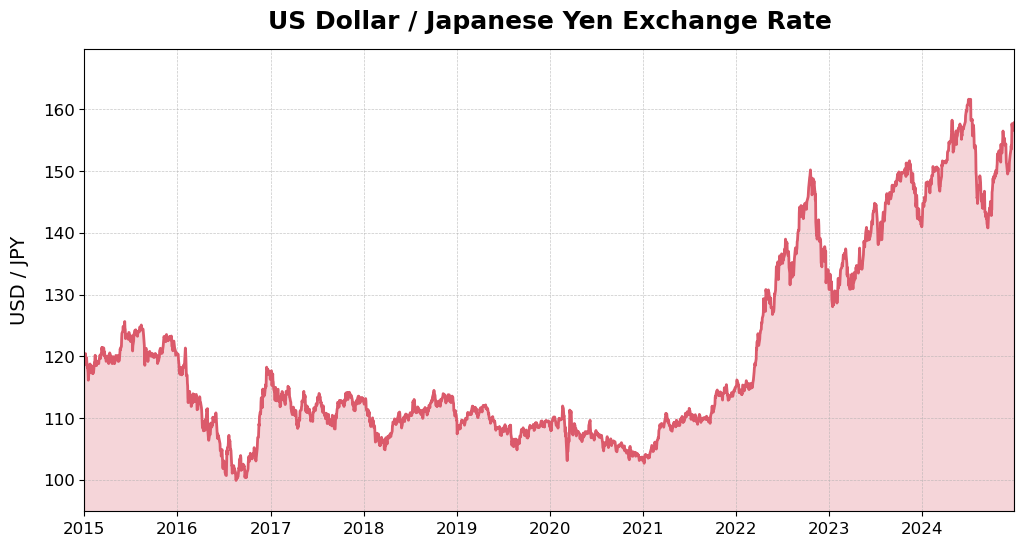

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(yen['Date'], yen['Close'], color='#DB5A6B', lw=2, label='USD / JPY')
plt.fill_between(yen['Date'], yen['Close'], color='#DB5A6B', alpha=0.25)
plt.title('US Dollar / Japanese Yen Exchange Rate', fontsize=18, fontweight='bold', pad=15)
plt.ylabel('USD / JPY', fontsize=14, labelpad=10)
plt.xlim(min(yen['Date']), max(yen['Date']))
plt.ylim(min(yen['Close']) * 0.95, max(yen['Close']) * 1.05)
plt.grid(which='major', linestyle='--', lw=0.5, alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Between 2015 and 2021, the exchange rate fluctuated between 100 JPY and 130 JPY per USD, trending downward. In 2022, the rate began to spike, eventually breaking past 160 JPY per USD by 2024. The surge in volatility post-2021 presents a challenge for forecasting models, which often perform better in more stable regimes. Hence the need to implement regime detection.

### Return and Volatility

To implement regime detection, we can look at grouping the datapoints by return and volatility. A training set consisting of only the first half will be created to avoid data leakage.

Calculate the return as the percentage change from the previous day's return, and the volatility as the rolling volatility of a window of 20 days.

In [6]:
d_split = '2020-01-01'
yen_train = yen[yen['Date'] < d_split].copy()

yen_train['Return'] = yen_train['Close'].pct_change() # Returns
yen_train['Volatility'] = yen_train['Return'].rolling(window=20).std() # Rolling Volatility
yen_train.dropna(inplace=True) # Drop missing values
yen_train[['Return', 'Volatility']] = StandardScaler().fit_transform(yen_train[['Return', 'Volatility']])

In [7]:
yen_train

,Date,Close,Return,Volatility
20,2015-01-29,117.592003,-0.285749,1.397682
21,2015-01-30,118.248001,1.067230,1.462972
22,2015-02-02,117.183998,-1.697887,1.522097
23,2015-02-03,117.574997,0.641939,1.457258
24,2015-02-04,117.646004,0.123561,1.397707
...,...,...,...,...
1296,2019-12-25,109.383003,0.010732,-1.349805
1297,2019-12-26,109.369003,-0.015280,-1.382844
1298,2019-12-27,109.542000,0.309052,-1.378554
1299,2019-12-30,109.428001,-0.188413,-1.372755


Plot the normalized returns and volatility on a time-series graph.

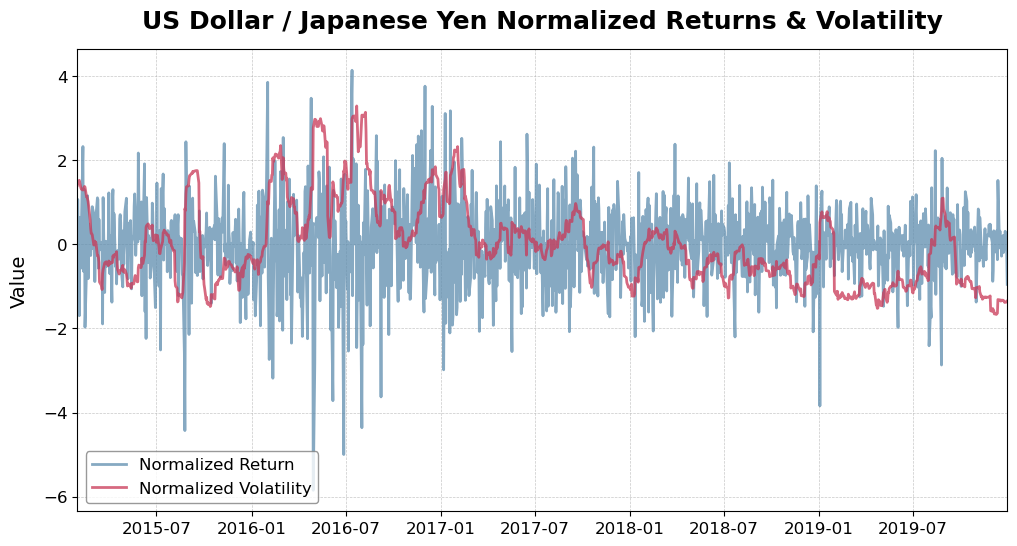

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(yen_train['Date'], yen_train['Return'], color='#5D8CAE', lw=2, alpha=0.75, label='Normalized Return')
plt.plot(yen_train['Date'], yen_train['Volatility'], color='#C93756', lw=2, alpha=0.75, label='Normalized Volatility')
plt.title('US Dollar / Japanese Yen Normalized Returns & Volatility', fontsize=18, fontweight='bold', pad=15)
plt.ylabel('Value', fontsize=14, labelpad=10)
plt.xlim(min(yen_train['Date']), max(yen_train['Date']))
plt.grid(which='major', linestyle='--', lw=0.5, alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, frameon=True, facecolor='white', edgecolor='gray', loc='lower left')
plt.show()

This plot shows clusters of increased/decreased return and volatility in 2016, early 2020, and the period from 2022 to 2023. 

## Regime Detection with $k$-Means Clustering

$k$-means clustering is used to identify market regimes given our return and volatility data. The elbow method is used to identify how many regimes are ideal. The choice of number of clusters ($k$) to use given the elbow method is arbitrary, and the number is usually determined on what the viewer finds ideal based on visual inspection.

### Elbow Method

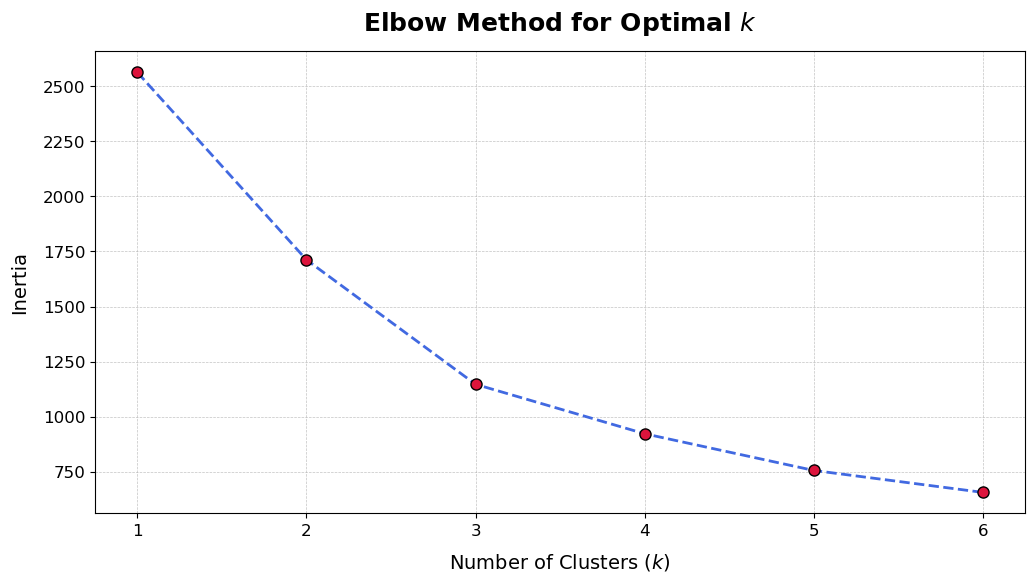

In [9]:
ke = range(1, 7)
inertias = []

for k in ke:
    model = KMeans(n_clusters=k)
    model.fit(yen_train[['Return', 'Volatility']])
    inertias.append(model.inertia_)

plt.figure(figsize=(12, 6))
plt.plot(ke, inertias, marker='o', color='royalblue', linestyle='--', lw=2, markersize=8, markerfacecolor='crimson', markeredgecolor='black')
plt.title('Elbow Method for Optimal $k$', fontsize=18, fontweight='bold', pad=15)
plt.xlabel('Number of Clusters ($k$)', fontsize=14, labelpad=10)
plt.ylabel('Inertia', fontsize=14, labelpad=10)
plt.grid(which='major', linestyle='--', lw=0.5, alpha=0.75)
plt.xticks(ke, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Looking at the plot, it can be observed that the optimal number of clusters is 3, as that is where the elbow point is. They should correspond to the three market regimes: Sideways, Bull, and Bear.

### Clustering

Now we can fit the $k$-means model with the optimal number of clusters ($k$).

In [10]:
kmeans_model = KMeans(n_clusters=3, random_state=120)
yen_train['K Regime'] = kmeans_model.fit_predict(yen_train[['Return', 'Volatility']])

Plot the returns compared to volatility colored by market regime.

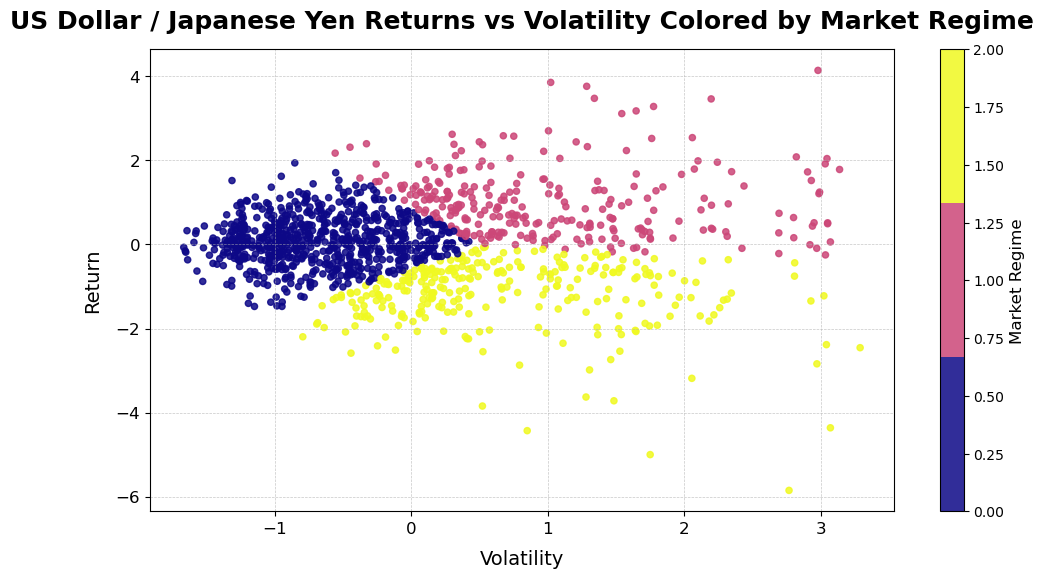

In [11]:
cmap = plt.colormaps['plasma'].resampled(3)
plt.figure(figsize=(12, 6))
scatter = plt.scatter(yen_train['Volatility'], yen_train['Return'], c=yen_train['K Regime'], cmap=cmap, s=20, alpha=0.85)
plt.title('US Dollar / Japanese Yen Returns vs Volatility Colored by Market Regime', fontsize=18, fontweight='bold', pad=15)
plt.xlabel('Volatility', fontsize=14, labelpad=10)
plt.ylabel('Return', fontsize=14, labelpad=10)
cbar = plt.colorbar(scatter)
cbar.set_label('Market Regime', fontsize=12)
plt.grid(which='major', linestyle='--', lw=0.5, alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

As shown, the $k$-means clustering appears to have created an imaginary line dividing each cluster, with one cluster representing low stable returns and lower volatility, another cluster representing higher returns and higher volatility, and a final cluster representing lower returns and higher volatility, they are labeled Regime 0, 1, and 2 in that order.

Now we can also plot the returns over time to see how each datapoint fits in the plot.

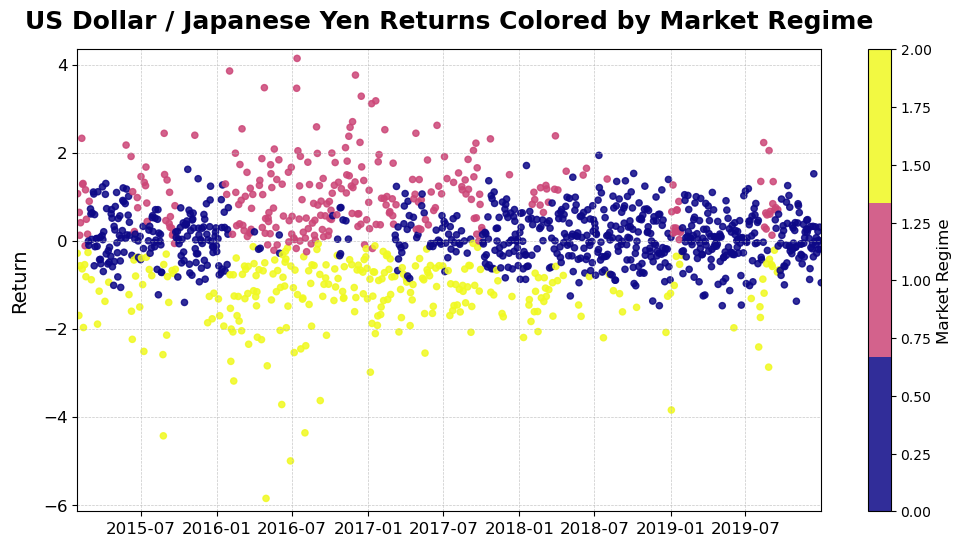

In [12]:
cmap = plt.colormaps['plasma'].resampled(3)
plt.figure(figsize=(12, 6))
scatter = plt.scatter(yen_train['Date'], yen_train['Return'], c=yen_train['K Regime'], cmap=cmap, s=20, alpha=0.85)
plt.title('US Dollar / Japanese Yen Returns Colored by Market Regime', fontsize=18, fontweight='bold', pad=15)
plt.ylabel('Return', fontsize=14, labelpad=10)
cbar = plt.colorbar(scatter)
cbar.set_label('Market Regime', fontsize=12)
plt.grid(which='major', linestyle='--', lw=0.5, alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(min(yen_train['Date']), max(yen_train['Date']))
plt.ylim(min(yen_train['Return']) * 1.05, max(yen_train['Return']) * 1.05)
plt.show()

It's apparent again that Regime 0 represents stable returns with low volatility, Regime 1 represents higher returns with higher volatility, and Regime 2 represents lower returns with higher volatility.

### Regime Summary

Create a summary of the regimes.

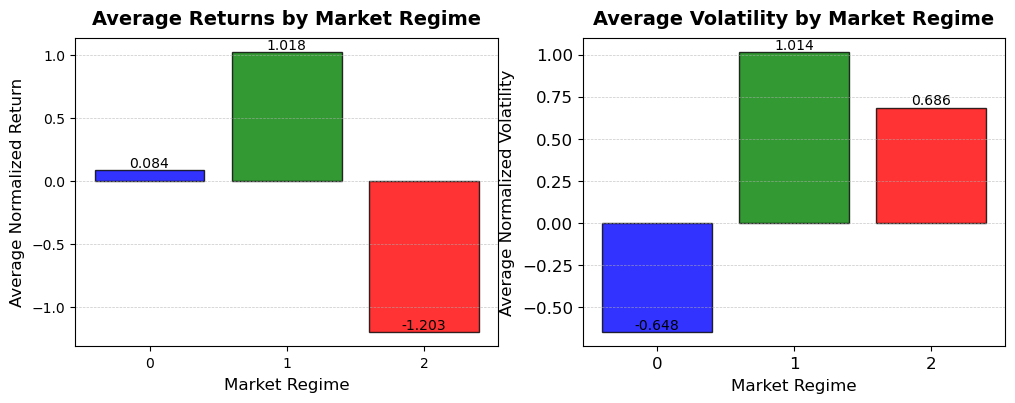

In [13]:
regime_summary = yen_train.groupby('K Regime').mean()[['Return', 'Volatility']]
regime_colors = ['blue', 'green', 'red']

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot Average Returns by Market Regime
axes[0].set_title('Average Returns by Market Regime', fontsize=14, fontweight='bold', pad=10)
bars1 = axes[0].bar(regime_summary.index, regime_summary['Return'], color=regime_colors, alpha=0.8, edgecolor='black')
axes[0].set_xlabel('Market Regime', fontsize=12, labelpad=5)
axes[0].set_ylabel('Average Normalized Return', fontsize=12, labelpad=5)
axes[0].grid(axis='y', linestyle='--', lw=0.5, alpha=0.7)
axes[0].set_xticks([0, 1, 2]) # Ensure only absolute integer labels (0, 1, 2)

# Plot Average Volatility by Market Regime
axes[1].set_title('Average Volatility by Market Regime', fontsize=14, fontweight='bold', pad=10)
bars2 = axes[1].bar(regime_summary.index, regime_summary['Volatility'], color=regime_colors, alpha=0.8, edgecolor='black')
axes[1].set_xlabel('Market Regime', fontsize=12, labelpad=5)
axes[1].set_ylabel('Average Normalized Volatility', fontsize=12, labelpad=5)
axes[1].grid(axis='y', linestyle='--', lw=0.5, alpha=0.7)
axes[1].set_xticks([0, 1, 2]) # Ensure only absolute integer labels (0, 1, 2)

for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom', fontsize=10)
for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

This again shows what has been stated in the previous analyses.

### Plot the Regimes

Create a time-series plot of the data, but color in the regimes.

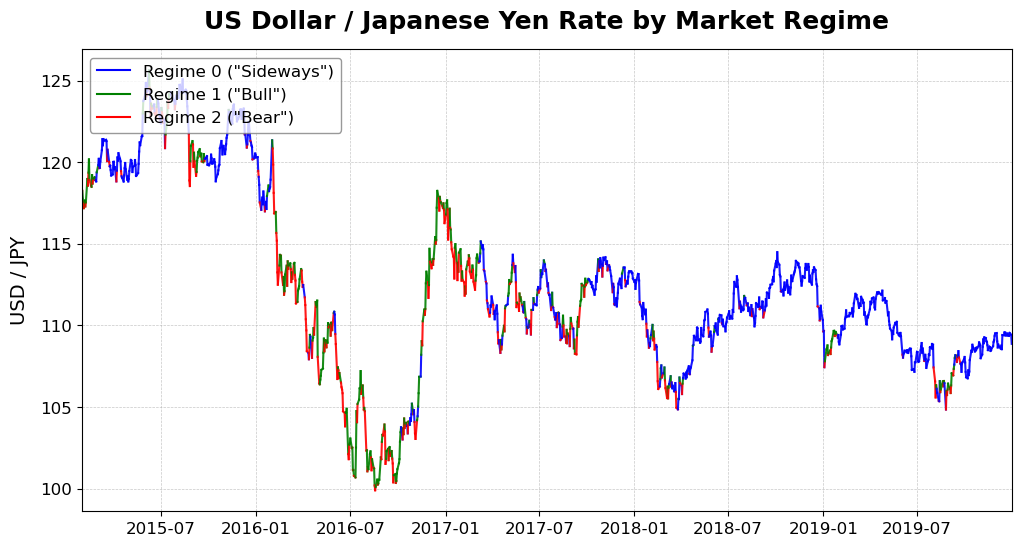

In [14]:
# Create a color map for the regimes
colors = {0: 'blue', 1: 'green', 2: 'red'}

plt.figure(figsize=(12, 6))
for i in range(1, len(yen_train.Close.values)):
    if yen_train['K Regime'].values[i] != yen_train['K Regime'].values[i-1]:  
        plt.plot(yen_train['Date'][i-1:i+1], yen_train.Close[i-1:i+1], 
                 color=colors[yen_train['K Regime'].values[i-1]], lw=1.5, alpha=0.9)
    else:  
        plt.plot(yen_train['Date'][i-1:i+1], yen_train.Close[i-1:i+1], 
                 color=colors[yen_train['K Regime'].values[i]], lw=1.5, alpha=0.9)
plt.title('US Dollar / Japanese Yen Rate by Market Regime', fontsize=18, fontweight='bold', pad=15)
plt.ylabel('USD / JPY', fontsize=14, labelpad=8)
plt.xlim(min(yen_train['Date']), max(yen_train['Date']))
plt.grid(which='major', linestyle='--', lw=0.5, alpha=0.7)
legend_elements = [Line2D([0], [0], color=colors[0], lw=1.5, label='Regime 0 ("Sideways")'),
                   Line2D([0], [0], color=colors[1], lw=1.5, label='Regime 1 ("Bull")'),
                   Line2D([0], [0], color=colors[2], lw=1.5, label='Regime 2 ("Bear")')]
plt.legend(handles=legend_elements, loc='upper left', fontsize=12, frameon=True, edgecolor='gray')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Regime -1, aka bear, appears when the exchange rate falls suddenly and usually ends at a trough. Regime 0, aka sideways, is the most dominant, and it occurs when the exchange rate is most stable. Regime 1, aka bull, appears usually when the exchange rate rises more than normally and stops at the peak.

## Model

Now that we know what the data looks like, and we have the necessary features, we can prepare it for the predictive model.

In [15]:
scaler = MinMaxScaler()
window_size = 60

In [16]:
yen_full = yen.copy()
yen_full['K Regime'] = 0  # Default for test period
yen_full.loc[yen_train.index, 'K Regime'] = yen_train['K Regime']

yen_full['Close'] = scaler.fit_transform(yen_full['Close'].values.reshape(-1, 1))

onehot = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
k_regime_reshaped = yen_full['K Regime'].values.reshape(-1, 1)
k_regime_encoded = onehot.fit_transform(k_regime_reshaped)

close_column = yen_full['Close'].values.reshape(-1, 1)
data_all = np.concatenate([close_column, k_regime_encoded], axis=1)

# Fallback to closest previous date if d_split not in 'Date'
if d_split not in yen_full['Date'].values:
    d_split = yen_full[yen_full['Date'] < pd.to_datetime(d_split)]['Date'].max()

if pd.isna(d_split):
    raise ValueError("d_split is earlier than the earliest date in the dataset.")

split_idx = yen_full[yen_full['Date'] == d_split].index[0]

X_train, y_train = [], []
for i in range(window_size, split_idx):
    X_train.append(data_all[i - window_size:i])
    y_train.append(data_all[i, 0])  # Close price (scaled)

X_test, y_test, test_dates = [], [], []
for i in range(split_idx, len(data_all)):
    X_test.append(data_all[i - window_size:i])
    y_test.append(data_all[i, 0])
    test_dates.append(yen_full.iloc[i]['Date'])

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
test_dates = np.array(test_dates)

### LSTM Model

Now we can prepare and run the neural network. LSTM has been chosen for this project as its memory structure allows it to capture long-term dependencies and lag relationships, making it ideal for time-series datasets. The model architecture includes:

* **LSTM Layers**: Captures long-term dependencies from a 60-day input sequence. It returns the hidden state corresponding to the final time step, summarizing the past window.
* **Swish Activation (SiLU)**: An activation function at the end.
* **Dropout Layers**: Regularization layers applied to prevent overfitting.
* **Fully Connected Layers**: A stack of dense layers that transform the LSTM output into the final scalar prediction.

In [17]:
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(X_train.shape[2], 1280, 3, batch_first=True, dropout=0.5)
        self.silu = nn.SiLU() # Swish Activation
        self.dropout = nn.Dropout(0.5) # Dropout
        self.fc1 = nn.Linear(1280, 640)
        self.fc2 = nn.Linear(640, 320)
        self.fc3 = nn.Linear(320, 160)
        self.fc4 = nn.Linear(160, 80)
        self.fc5 = nn.Linear(80, 40)
        self.fc6 = nn.Linear(40, 1)
  
    def forward(self, x):
        x, _ = self.lstm(x) # LSTM layers
        x = x[:, -1, :] # Normalize Output
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.dropout(x)
        x = self.fc4(x)
        x = self.dropout(x)
        x = self.fc5(x)
        x = self.dropout(x)
        x = self.fc6(x)
        x = self.silu(x) # Activation
        return x

This initializes the model and trains it over 10 epochs using the RAdam optimizer and mean squared error loss.

In [18]:
torch.manual_seed(120)

model = LSTMModel().to(device)
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.15)

num_epochs = 150
batch_size = 1
train_losses, val_losses = [], []
epoch_times = []

patience = 15
best_val_loss = float('inf')
patience_counter = 0
best_model_wts = copy.deepcopy(model.state_dict())

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    train_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            val_loss += loss.item() * X_batch.size(0)

    val_loss /= len(test_loader.dataset)
    val_losses.append(val_loss)
    scheduler.step(val_loss)
    epoch_times.append(time.time() - start_time)
    
    print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}, Time: {epoch_times[-1]:.2f} seconds")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

model.load_state_dict(best_model_wts)

total_time = sum(epoch_times)
best_epoch = val_losses.index(min(val_losses)) + 1
print(f"\nTraining completed in {total_time:.2f} seconds")
print(f"Best model selected from epoch {best_epoch} with validation loss: {min(val_losses):.5f}")

/home/staszewski/anaconda3/lib/python3.12/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Epoch 1, Train Loss: 0.00961, Val Loss: 0.07042, Time: 19.31 seconds
Epoch 2, Train Loss: 0.00663, Val Loss: 0.05421, Time: 19.38 seconds
Epoch 3, Train Loss: 0.00539, Val Loss: 0.00284, Time: 23.04 seconds
Epoch 4, Train Loss: 0.00462, Val Loss: 0.00289, Time: 23.14 seconds
Epoch 5, Train Loss: 0.00351, Val Loss: 0.00130, Time: 21.38 seconds
Epoch 6, Train Loss: 0.00337, Val Loss: 0.00858, Time: 20.22 seconds
Epoch 7, Train Loss: 0.00321, Val Loss: 0.00630, Time: 23.11 seconds
Epoch 8, Train Loss: 0.00284, Val Loss: 0.00246, Time: 19.56 seconds
Epoch 9, Train Loss: 0.00279, Val Loss: 0.01527, Time: 19.35 seconds
Epoch 10, Train Loss: 0.00249, Val Loss: 0.00194, Time: 19.14 seconds
Epoch 11, Train Loss: 0.00229, Val Loss: 0.00093, Time: 19.30 seconds
Epoch 12, Train Loss: 0.00227, Val Loss: 0.00181, Time: 19.19 seconds
Epoch 13, Train Loss: 0.00229, Val Loss: 0.00710, Time: 19.18 seconds
Epoch 14, Train Loss: 0.00209, Val Loss: 0.00352, Time: 19.16 seconds
Epoch 15, Train Loss: 0.00207

Plot the training and validation loss over the epochs.

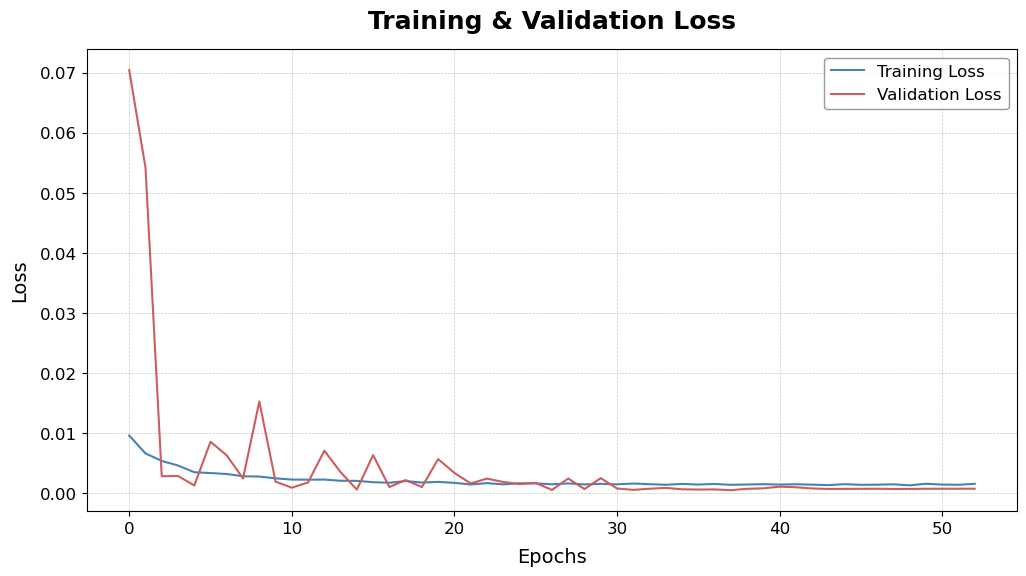

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss', color='steelblue', lw=1.5)
plt.plot(val_losses, label='Validation Loss', color='indianred', lw=1.5)
plt.title('Training & Validation Loss', fontsize=18, fontweight='bold', pad=15)
plt.xlabel('Epochs', fontsize=14, labelpad=8)
plt.ylabel('Loss', fontsize=14, labelpad=8)
plt.grid(which='major', linestyle='--', lw=0.5, alpha=0.7)
plt.legend(fontsize=12, frameon=True, edgecolor='gray', loc='upper right')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

As shown, the model appears to learn rapidly with the validation loss falling quickly to meet the training loss.

### Model Results

Now we can test our results.

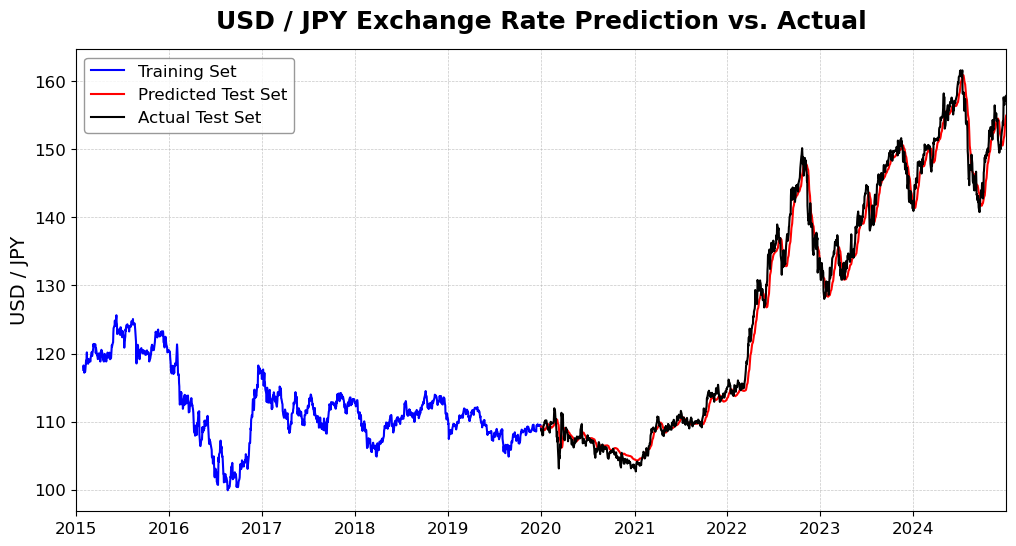

In [20]:
# Testing and Evaluation
model.eval()
with torch.no_grad():
    predictions = []
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        preds = model(X_batch)
        predictions.extend(preds.cpu().numpy())
# Inverse scale predictions and actual values
y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1))
y_test_pred = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Get correct test dates
train_dates = yen_train['Date'].values
train_close = scaler.inverse_transform(
    yen_full.loc[yen_train.index, 'Close'].values.reshape(-1, 1)
)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train_dates, train_close, label="Training Set", color='blue', lw=1.5)
plt.plot(test_dates, y_test_pred, label="Predicted Test Set", color='red', lw=1.5)
plt.plot(test_dates, y_test_true, label="Actual Test Set", color='black', lw=1.5)

plt.title('USD / JPY Exchange Rate Prediction vs. Actual', fontsize=18, fontweight='bold', pad=15)
plt.ylabel('USD / JPY', fontsize=14)
plt.grid(which='major', linestyle='--', lw=0.5, alpha=0.7)
plt.legend(fontsize=12, frameon=True, edgecolor='gray', loc='upper left')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(min(yen['Date']), max(yen['Date']))
plt.show()

Plot the predicted test set and compare the results to the actual test set.

This appears to be a very good fit!

Now calculate the test loss and accuracy.

In [21]:
def test_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        y_pred = model(torch.tensor(X_test).float().to(device))
    y_pred = y_pred.detach().cpu().numpy().flatten()

    test_loss = mean_absolute_error(y_test, y_pred)
    accuracy = 1 - mean_absolute_percentage_error(y_test, y_pred)

    actual_diff = np.diff(y_test)
    predicted_diff = np.diff(y_pred)

    actual_dir = np.sign(actual_diff)
    predicted_dir = np.sign(predicted_diff)

    directional_matches = (actual_dir == predicted_dir)
    directional_accuracy = np.mean(directional_matches)

    return y_pred, test_loss, accuracy, directional_accuracy

y_test_pred1, test_loss, accuracy, dir_accuracy = test_model(model, X_test, y_test)

print(f"Test Loss (MAE): {test_loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Directional Accuracy: {dir_accuracy:.4f}")

Test Loss (MAE): 0.0243
Test Accuracy: 0.9217
Directional Accuracy: 0.5330


Excellent results!

# Algorithmic Trading

This section will utilize the predicted values and actual values of the exchange rate between the US dollar ($) to Japanese yen (¥) to perform algorithmic trading from a five-year period between 2020 and 2024.

In [22]:
prices = pd.DataFrame({
    'Date': test_dates,
    'Actual': y_test_true.flatten(),
    'Predicted': y_test_pred.flatten()
})

Plot the predicted results vs actual results.

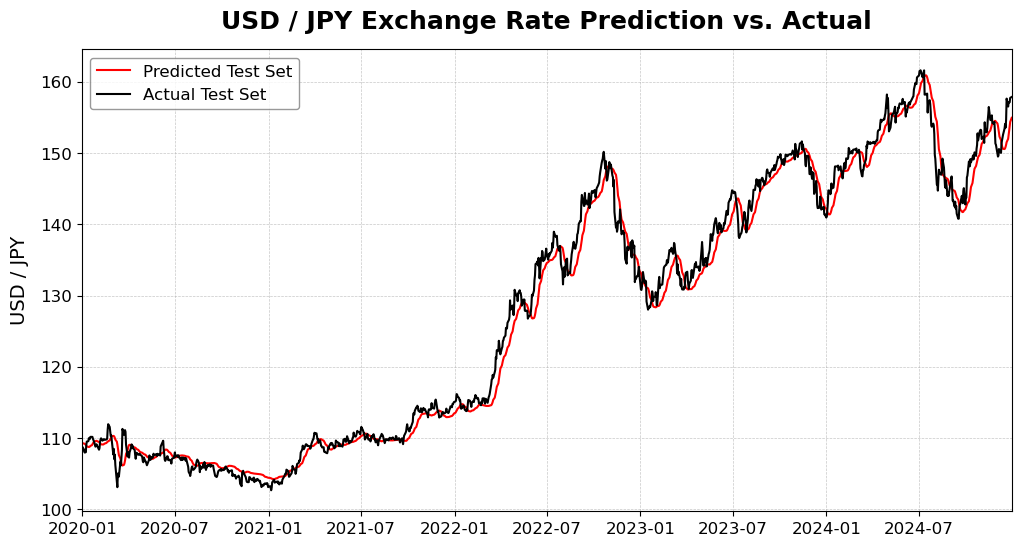

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(prices['Date'], prices['Predicted'], label="Predicted Test Set", color='red', lw=1.5)
plt.plot(prices['Date'], prices['Actual'], label="Actual Test Set", color='black', lw=1.5)
plt.title('USD / JPY Exchange Rate Prediction vs. Actual', fontsize=18, fontweight='bold', pad=15)
plt.ylabel('USD / JPY', fontsize=14, labelpad=8)
plt.xlim(prices['Date'].min(), prices['Date'].max())
plt.grid(which='major', linestyle='--', lw=0.5, alpha=0.7)
plt.legend(fontsize=12, frameon=True, edgecolor='gray', loc='upper left')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

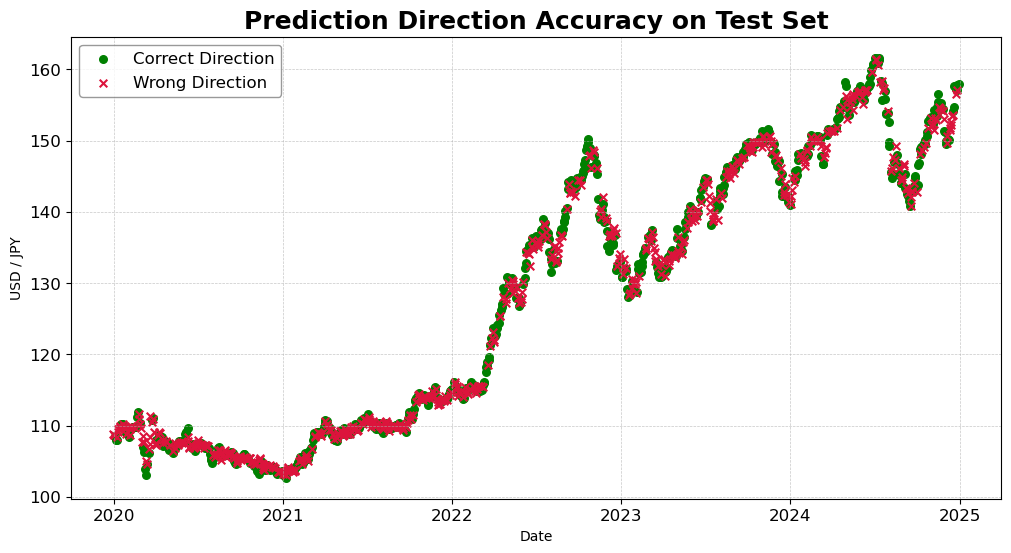

In [24]:
prices['Actual_Diff'] = prices['Actual'].diff()
prices['Predicted_Diff'] = prices['Predicted'].diff()
prices['Direction_Correct'] = (np.sign(prices['Actual_Diff']) == np.sign(prices['Predicted_Diff'])).astype(int)

plt.figure(figsize=(12, 6))
#plt.plot(prices['Date'], prices['Actual'], label="Actual", color='black', lw=1.5)
#plt.plot(prices['Date'], prices['Predicted'], label="Predicted", color='red', lw=1.5)

plt.scatter(
    prices.loc[prices['Direction_Correct'] == 1, 'Date'],
    prices.loc[prices['Direction_Correct'] == 1, 'Actual'],
    color='green', marker='o', label='Correct Direction', s=30
)
plt.scatter(
    prices.loc[prices['Direction_Correct'] == 0, 'Date'],
    prices.loc[prices['Direction_Correct'] == 0, 'Actual'],
    color='crimson', marker='x', label='Wrong Direction', s=30
)

plt.title('Prediction Direction Accuracy on Test Set', fontsize=18, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('USD / JPY')
plt.grid(True, linestyle='--', lw=0.5, alpha=0.7)
plt.legend(fontsize=12, frameon=True, edgecolor='gray')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [25]:
def apply_holding_period(signal_series, holding_days):
    held_signal = []
    countdown = 0
    current_signal = 0

    for sig in signal_series:
        if countdown > 0:
            held_signal.append(current_signal)
            countdown -= 1
        elif sig != 0:
            current_signal = sig
            countdown = holding_days - 1
            held_signal.append(current_signal)
        else:
            current_signal = 0
            held_signal.append(0)

    return held_signal

# Compute basic strategy signals
v_predicted_change = np.diff(prices['Predicted'].to_numpy(), 1)
v_predicted_change = np.insert(v_predicted_change, 0, 0)

# Threshold
threshold = 0.02
v_predicted_change[np.abs(v_predicted_change) < threshold] = 0

prices['v_long_raw'] = np.maximum(np.sign(v_predicted_change), 0)
prices['v_longshort_raw'] = np.sign(v_predicted_change)
prices['v_proportional_raw'] = np.clip(v_predicted_change, -1, 1)

# Apply holding period
holding_days = 3
prices['v_long'] = apply_holding_period(prices['v_long_raw'], holding_days)
prices['v_longshort'] = apply_holding_period(prices['v_longshort_raw'], holding_days)
prices['v_proportional'] = apply_holding_period(prices['v_proportional_raw'], holding_days)

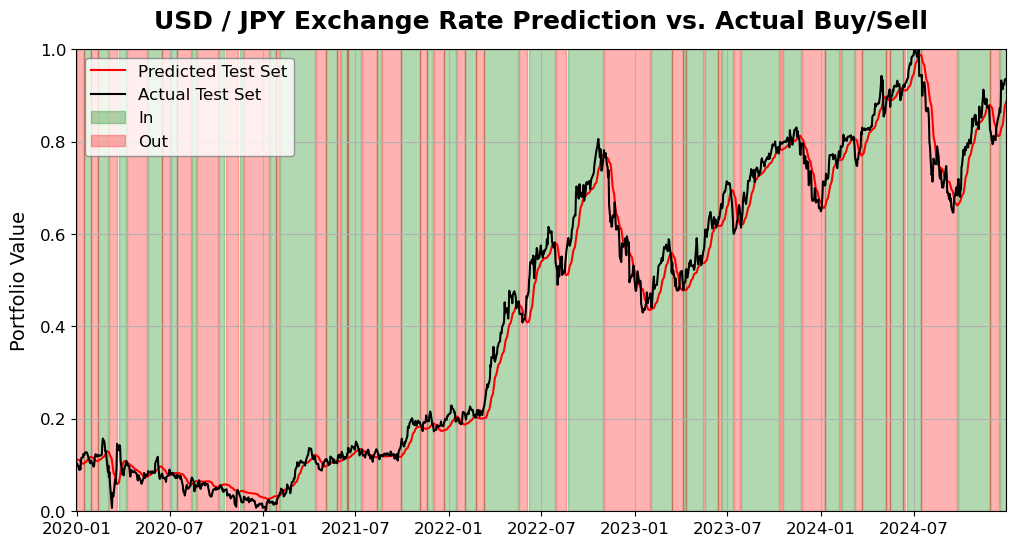

In [26]:
# Get combined min and max from both Actual and Predicted
combined_min = min(prices['Actual'].min(), prices['Predicted'].min())
combined_max = max(prices['Actual'].max(), prices['Predicted'].max())

# Apply consistent min-max normalization
prices['Actual_norm'] = (prices['Actual'] - combined_min) / (combined_max - combined_min)
prices['Predicted_norm'] = (prices['Predicted'] - combined_min) / (combined_max - combined_min)

plt.figure(figsize=(12, 6))
plt.plot(prices.Date, prices.Predicted_norm, label="Predicted Test Set", color='red', lw=1.5)
plt.plot(prices.Date, prices.Actual_norm, label="Actual Test Set", color='black', lw=1.5)
plt.fill_between(prices.Date, 0, 1, where=prices['v_long'] == 1, color='green', alpha=0.3, label="In")
plt.fill_between(prices.Date, 0, 1, where=prices['v_long'] == 0, color='red', alpha=0.3, label="Out")
plt.grid(axis="both")
plt.title('USD / JPY Exchange Rate Prediction vs. Actual Buy/Sell', fontsize=18, fontweight='bold', pad=15)
plt.xlim(min(prices['Date']), max(prices['Date']))
plt.ylim(0, 1)
plt.legend(fontsize=12, frameon=True, edgecolor='gray', loc='upper left')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Portfolio Value', fontsize=14, labelpad=8)
plt.show()

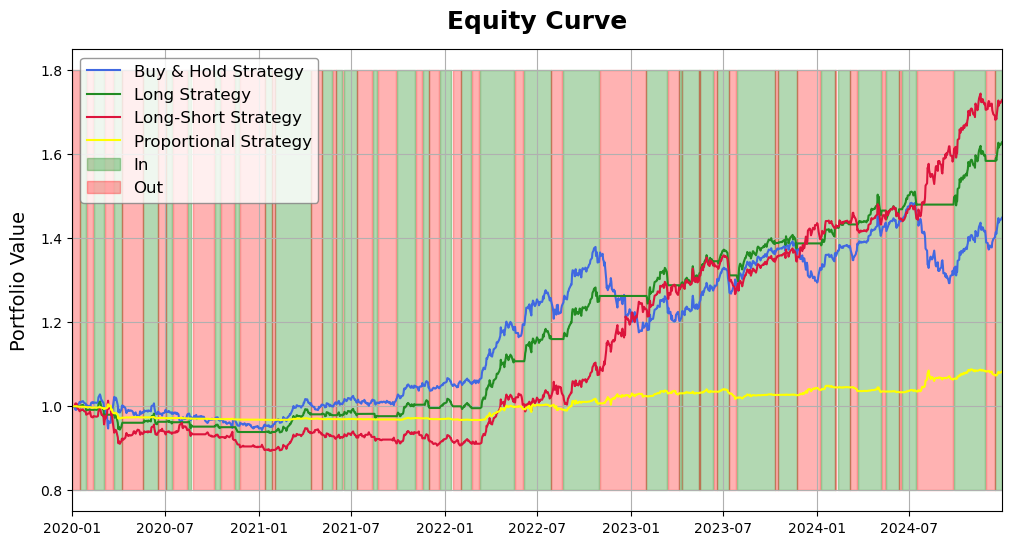

In [31]:
prices['v_buyhold'] = 1

# Compute return ratio
prices['rapp'] = prices['Actual'].pct_change().fillna(0) + 1

# Define gross portfolio value computation
def gross_portfolio(df, strategy_col):
    w = df[strategy_col].values
    return [(w * df["rapp"] + (1 - w))[:i].prod() for i in range(len(w))]

def gross_portfolio_longshort(df, strategy_col):
    w = df[strategy_col].values
    return [(w * (df["rapp"] - 1) + 1)[:i].prod() for i in range(len(w))]

# Compute portfolios and attach to DataFrame
prices['Portfolio_BuyHold'] = gross_portfolio(prices, 'v_buyhold')
prices['Portfolio_Long'] = gross_portfolio(prices, 'v_long')
prices['Portfolio_LongShort'] = gross_portfolio_longshort(prices, 'v_longshort')
prices['Portfolio_Proportional'] = gross_portfolio_longshort(prices, 'v_proportional')

plt.figure(figsize=(12, 6))
plt.plot(prices.Date, prices.Portfolio_BuyHold, label="Buy & Hold Strategy", color='royalblue', lw=1.5)
plt.plot(prices.Date, prices.Portfolio_Long, label="Long Strategy", color='forestgreen', lw=1.5)
plt.plot(prices.Date, prices.Portfolio_LongShort, label="Long-Short Strategy", color='crimson', lw=1.5)
plt.plot(prices.Date, prices.Portfolio_Proportional, label="Proportional Strategy", color='yellow', lw=1.5)

plt.fill_between(prices.Date, 0.8, 1.8, where=prices['v_long'] == 1, color='green', alpha=0.3, label="In")
plt.fill_between(prices.Date, 0.8, 1.8, where=prices['v_long'] == 0, color='red', alpha=0.3, label="Out")

plt.xlim(min(prices['Date']), max(prices['Date']))
#plt.ylim(0.9, 1.4)
plt.title('Equity Curve', fontsize=18, fontweight='bold', pad=15)
plt.ylabel('Portfolio Value', fontsize=14, labelpad=8)
plt.legend(fontsize=12, frameon=True, edgecolor='gray', loc='upper left')
plt.grid(True)
plt.show()

In [28]:
returns = pd.DataFrame({
    "BuyHold": prices['Portfolio_BuyHold'].pct_change(),
    "Long": prices['Portfolio_Long'].pct_change(),
    "LongShort": prices['Portfolio_LongShort'].pct_change(),
    "Proportional": prices['Portfolio_Proportional'].pct_change()
})

def yield_gross(df, v):
    prod = (v * df["rapp"].values + 1 - v).prod()
    n_years = len(v) / 252
    return (prod - 1) * 100, ((prod ** (1 / n_years)) - 1) * 100

def sharpe_ratio(series, risk_free_rate=0.01, ):
    excess_returns = series - risk_free_rate / 252
    return (excess_returns.mean() / excess_returns.std()) * np.sqrt(252)

v_buyhold = prices['v_buyhold'].values
v_long = prices['v_long'].values
v_longshort = prices['v_longshort'].values
v_proportional = prices['v_proportional'].values

sharpe_df = pd.DataFrame({
    "Method": ["Buy & Hold", "Long", "Long-Short", "Proportional"],
    "Sharpe Ratio": [
        round(sharpe_ratio(returns["BuyHold"].dropna()), 2),
        round(sharpe_ratio(returns["Long"].dropna()), 2),
        round(sharpe_ratio(returns["LongShort"].dropna()), 2),
        round(sharpe_ratio(returns["Proportional"].dropna()), 2)
    ]
})

results0 = pd.DataFrame({"Method": ["Buy & Hold", "Long", "Long-Short", "Proportional"]})
results1 = pd.DataFrame({"Method": ["Buy & Hold", "Long", "Long-Short", "Proportional"]})

vs = [v_buyhold, v_long, v_longshort, v_proportional]

results0["Total Gross Yield"] = [f"{round(yield_gross(prices, vi)[0], 2)} %" for vi in vs]
results1["Annual Gross Yield"] = [f"{round(yield_gross(prices, vi)[1], 2)} %" for vi in vs]

print(results0)
print("\n")
print(results1)
print("\n")
print(sharpe_df)

         Method Total Gross Yield
0    Buy & Hold           45.01 %
1          Long           62.99 %
2    Long-Short           73.05 %
3  Proportional            8.33 %


         Method Annual Gross Yield
0    Buy & Hold             7.44 %
1          Long             9.89 %
2    Long-Short            11.17 %
3  Proportional             1.56 %


         Method  Sharpe Ratio
0    Buy & Hold          0.71
1          Long          1.31
2    Long-Short          1.10
3  Proportional          0.21
